In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import os
import json
# --- 全局字体设置 ---
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 12
})

# --- Fitting Functions ---
def power_func_time(t, B, alpha):
    """Power-law function for time-dependent fitting: B * t^(-alpha)."""
    return B * np.power(t, -alpha)

def exp_func_time(t, A, tau):
    """Exponential decay function for time-dependent fitting: A * exp(-t / tau)."""
    return A * np.exp(-t / tau)

def power_law_corr(x, A, beta):
    """Power-law function for parametric fitting: y = A * x^beta."""
    return A * np.power(x, beta)

def load_and_combine_data(directory_path):
    """
    Reads multiple correlation data files from a given directory, standardizes their
    column names, and merges them into a single Pandas DataFrame.

    This function acts as a flexible data-loading interface. To add a new data file,
    simply add an entry to the 'column_map' dictionary.

    Args:
        directory_path (str): The path to the directory containing the .dat files.

    Returns:
        pandas.DataFrame: A single DataFrame containing all merged data, with columns
                          like 't', 'DoubleCorrZ', 'ErrDoubleZ', etc. Returns None
                          if no data could be loaded.
    """
    # --- This map is the core of the interface ---
    # It links new filenames to the old, standardized DataFrame column names.
    # To add a new file (e.g., height_t_corr.dat), just add a new line here.
    column_map = {
        # 'new_filename.dat': {'col_in_file': 'standard_col_name', ...}
        'szsz_t_corr.dat':   {'t': 't', 'Avg': 'DoubleCorrZ', 'Err': 'ErrDoubleZ'},
        'oo_t_corr.dat':     {'t': 't', 'Avg': 'DoubleCorrO', 'Err': 'ErrDoubleO'},
        'sz_autocorr.dat':   {'t': 't', 'Avg': 'Sz_Autocorr_Avg',   'Err': 'Sz_Autocorr_Err'},
        'height_t_corr.dat': {'t': 't', 'Avg': 'HH_t_Avg',       'Err': 'HH_t_Err'},
        'height_diffusion.dat': {'t': 't', 'Avg': 'Height_Diff_A_Avg', 'Err': 'Height_Diff_A_Err'},
        # 'final_grand_average_equal.dat': {'r': 'r', 'Avg': 'DoubleCorrZ', 'Err': 'ErrDoubleZ', 'Avg': 'DoubleCorrO', 'Err': 'ErrDoubleO'},
        'final_grand_average_time.dat': {'t': 't', 'Avg1': 'DoubleCorrZ', 'Err1': 'ErrDoubleZ', 'Avg': 'DoubleCorrO', 'Err': 'ErrDoubleO'},
        # Add other time-correlations here if needed
        # 'szsz_r_corr.dat': {'r': 'r', 'Avg': 'CorrZ_r', 'Err': 'ErrCorrZ_r'},
    }

    list_of_dfs = []
    base_column = None # Will be 't' or 'r'

    for filename, name_map in column_map.items():
        full_path = os.path.join(directory_path, filename)
        try:
            # Read the individual data file
            temp_df = pd.read_csv(full_path, sep='\s+')
            
            # The first successfully read file determines the base column ('t' or 'r')
            if base_column is None:
                if 't' in temp_df.columns:
                    base_column = 't'
                elif 'r' in temp_df.columns:
                    base_column = 'r'
            
            # Rename columns to the standard format
            temp_df.rename(columns=name_map, inplace=True)
            
            # Keep only the standardized columns
            list_of_dfs.append(temp_df[list(name_map.values())])

        except FileNotFoundError:
            # It's okay if some files are missing, just skip them.
            # print(f"Info: File not found '{full_path}', skipping.")
            pass
        except Exception as e:
            print(f"Error reading file {full_path}: {e}")

    if not list_of_dfs:
        print(f"Warning: No data files found in {directory_path}")
        return None

    # --- Merge all the individual DataFrames into one ---
    # Start with the first DataFrame in the list
    combined_df = list_of_dfs[0]
    
    # Iteratively merge the rest of the DataFrames
    for df_to_merge in list_of_dfs[1:]:
        combined_df = pd.merge(combined_df, df_to_merge, on=base_column, how='outer')

    # Sort by the base column for consistency
    combined_df.sort_values(by=base_column, inplace=True)
    
    return combined_df


In [24]:
# --- NEW: Refactored Main Plotting Function (Corrected Version) ---
def generate_collapse_plot(
    datasets,
    plot_configs,
    z,
    output_filename,
    axis_limits=None,
    do_parametric_plot=False,
    fit_config_parametric=None,
    ncols = 1
):
    """
    A general function to create data collapse plots based on a configuration list.
    (Corrected version with parametric fitting restored).
    """
    # --- 1. Dynamic Figure Setup ---
    num_subplots = len(plot_configs)
    if do_parametric_plot:
        num_subplots += 1
    
    fig, axes = plt.subplots(nrows=int(num_subplots/ncols), ncols=ncols, figsize=(12*ncols, 8 * num_subplots), squeeze=False)
    axes = axes.flatten() # Ensure axes is always a flat array

    all_scaled_data = {}
    all_raw_data = {} # For parametric plot

    # --- 2. Data Loading and Scaling ---
    for dataset in datasets:
        L, S = dataset["L"], dataset.get("S", 1)
        df_initialized = False
        try:
            directory_path = f"./puredata/data/L{L}_S{S}_T{dataset['T']}_Tthermal{dataset['Tthm']}/final_grand_average_time.dat"
            # print()
            # Attempt to load the data
            tempdf = pd.read_csv(directory_path, sep='\s+')
            # Identify columns that are likely causing issues (the ones you use for plotting)
            # cols_to_clean = ['AutoZ', 'DoubleCorrZ', 'DoubleCorrO', 'AutoC', 'AutoCErr', 'DoubleCorrZErr', 'DoubleCorrOErr'] 
            
            # Check if df has been initialized
            if not df_initialized:
                df = tempdf.copy() # Use .copy() to be safe
                df_initialized = True
            else:
                # If df is already initialized, use concat to combine
                df = pd.concat([df, tempdf], ignore_index=True, join='outer') 
                # Note: pd.concat is often preferred for combining dataframes with different indices/columns
            
        except FileNotFoundError:
            # Pass silently if the directory/file isn't found
            pass 
        except Exception as e:
            # Catch other potential errors, but print a message for debugging
            print(f"An error occurred with the first data source: {e}")
            pass

        # --- Second Data Source ---
        try:
            # directory_path = f"./puredata/data/L{L}_S{S}_T{dataset['T']}_Tthermal{dataset['Tthm']}/final_grand_average_time.dat"
            directory_path = f"./puredata/data/L{L}_S{S}_T{dataset['T']}_Tthermal{dataset['Tthm']}/final_grand_average_time.dat"
            # print(directory_path)
            # Attempt to load the data
            tempdf = pd.read_csv(directory_path, sep='\s+')
            
            # Check if df has been initialized
            if not df_initialized:
                df = tempdf.copy()
                df_initialized = True
            else:
                # Combine with the existing df
                df = pd.concat([df, tempdf], ignore_index=True, join='outer')
            # df["P1_Avg"] = df["C_Nm1m1_Avg"]+df["C_Nm1m-1_Avg"]
            # df["P1_Err"] = np.sqrt(df["C_Nm1m1_Avg"]**2+df["C_Nm1m-1_Avg"]**2)
            # if S>1:
            #     df["P2_Avg"] = df["C_Nm2m2_Avg"]+df["C_Nm2m-2_Avg"]
            #     df["P2_Err"] = np.sqrt(df["C_Nm2m2_Avg"]**2+df["C_Nm2m-2_Avg"]**2)

        except FileNotFoundError:
            # Pass silently if the directory/file isn't found
            pass
        except Exception as e:
            # Catch other potential errors, but print a message for debugging
            print(f"An error occurred with the second data source: {e}")
            pass
        # print("b",L,S,df_initialized)
        if  df_initialized:
            # print(L,S,df)
            t = df["t"].values
            t_scaled = t / (L ** z)
            all_scaled_data[L] = {'t_scaled': t_scaled}
            
            for ax, config in zip(axes, plot_configs):
                data_col, err_col = config['data_col'], config.get('err_col')
                if data_col not in df.columns: continue
                scaling_exp, log_power = config.get('scaling_exponent', 0), config.get('log_power', 0)
                scaling_factor = (L ** scaling_exp) / (np.log(L) ** log_power if L > 1 else 1)*config.get("coef", 1.0)
                # print(df[data_col].values)
                scaled_y = (df[data_col].values) * scaling_factor
                all_scaled_data[L][data_col] = scaled_y
                if dataset.get("plot_errorbars", False) and err_col and err_col in df.columns:
                    scaled_err = df[err_col].values 
                    ax.errorbar(t_scaled, scaled_y, yerr=scaled_err, fmt='o', markersize=3, capsize=3, label=f"L={L}")
                else:
                    ax.plot(t_scaled, scaled_y, 'o', markersize=3, label=f"L={L}")
            
            if do_parametric_plot and 'DoubleCorrZ' in df.columns and 'DoubleCorrO' in df.columns:
                mask = (df["DoubleCorrZ"] > 0) & (df["DoubleCorrO"] > 0)
                all_raw_data[L] = {
                    "corrZ_raw": df["DoubleCorrZ"][mask].values,
                    "corrO_raw": np.float64(df["DoubleCorrO"][mask].values)
                }
                axes[-1].plot(all_raw_data[L]["corrZ_raw"], all_raw_data[L]["corrO_raw"], 'o', markersize=3, label=f"L={L}")
    ### NEW: Initialize a dictionary to store the fitted tau values.
    fitted_taus = {}
    # --- 3. Generalized Fitting for Main Plots ---
    ### NEW: Create a map to easily get S from L later on.
    L_to_S_map = {d['L']: d.get('S', 1) for d in datasets}
    for ax, config in zip(axes, plot_configs):
        use_semilogy = any(fit[2] == 'exp' for fit in config.get('fit_configs', []) if len(fit) == 3)
        
        if 'fit_configs' in config:
            print(f"\n--- Fitting for plot of {config['data_col']} ---")
            for target_L, (t_min, t_max), fit_type in config.get('fit_configs', []):
                if target_L not in all_scaled_data: continue
                t_s, c_y = all_scaled_data[target_L]['t_scaled'], all_scaled_data[target_L][config['data_col']]
                # Create the mask to select data in the fitting range
                mask = (t_s >= t_min) & (t_s <= t_max) & (c_y > 0)
                if not np.any(mask): continue
                
                # --- BUG FIX STARTS HERE ---
                # Define a specific, correct initial guess for each fit type
                if fit_type == 'power':
                    fit_func, p_idx, label_tmpl = power_func_time, 1, "L={L} Pow Fit: $t^{{-{val:.2f}}}$"
                    t_fit = np.logspace(np.log10(max(1e-9, t_min*0.1)), np.log10(t_max*10), 200)
                    # A robust guess for power law: amplitude is max value, exponent is 1.0
                    p0_guess = [c_y[mask].max(), 1.0] 
                elif fit_type == 'exp':
                    fit_func, p_idx, label_tmpl = exp_func_time, 1, "L={L} Exp Fit: $\\tau={val:.2f}$"
                    t_fit = np.linspace(t_min*0.5, t_max*2, 200)
                    # The original guess is good for exponential decay's tau
                    p0_guess = [c_y[mask].max(), (t_max - t_min) / 2]
                else:
                    continue # Skip unknown fit types
                
                # Perform the fit using the correct initial guess
                try:
                    popt, _ = curve_fit(fit_func, t_s[mask], c_y[mask], p0=p0_guess)
                    ### NEW: If the fit was exponential, store the tau value.
                    if fit_type == 'exp':
                        current_S = L_to_S_map.get(target_L)
                        if current_S is not None:
                            tau_val = popt[1]  # tau is the second parameter
                            s_key = f"S={current_S}" # Create a key like "S=1", "S=3", etc.
                            
                            # Initialize dictionary for this S if it doesn't exist
                            if s_key not in fitted_taus:
                                fitted_taus[s_key] = {}
                            
                            # Store the tau value for the current L
                            fitted_taus[s_key][target_L] = tau_val
                            print(f"  => Stored tau = {tau_val:.4f} for S={current_S}, L={target_L}")

                    ax.plot(t_fit, fit_func(t_fit, *popt), '--', label=label_tmpl.format(L=target_L, val=popt[p_idx]))
                except RuntimeError:
                    print(f"  Warning: Fit did not converge for L={target_L} in range [{t_min}, {t_max}].")
        print(use_semilogy)     
        if use_semilogy:
            ax.set_xscale('linear'); ax.set_yscale('log')
        else:
            ax.set_xscale('log'); ax.set_yscale('log')
        # ax.set_xscale('linear'); ax.set_yscale('linear')
        if z != 0:
            ax.set_xlabel(r"Scaled Time $t/L^z$")
        else:
            ax.set_xlabel(r"Time $t$")
        if config.get('scaling_exponent', 0) == 0 and config.get('log_power', 0) == 0:
            ax.set_ylabel(rf"${config['label']}$")
        else:
            ax.set_ylabel(rf"${config['label']} \cdot L^{{{config.get('scaling_exponent', 0)}}} / (\ln L)^{{{config.get('log_power', 0)}}}$")
        ax.set_title(f"Data Collapse of ${config['label']}$ (z = {z}) (S = {S})")
        ax.legend(); ax.grid(True, which="both", ls="--")

    # --- 4. RESTORED: Fitting loop for Parametric Plot ---
    if do_parametric_plot and fit_config_parametric and all_raw_data:
        ax_para = axes[-1] # The parametric plot is always the last one
        print("\n--- Performing parametric fitting... ---")
        print(fit_config_parametric)
        for target_L, (z_min, z_max) in fit_config_parametric:
            if target_L not in all_raw_data:
                print(f"  Warning: L={target_L} raw data not available for parametric fitting. Skipping.")
                continue

            print(f"  Fitting for L={target_L} in parametric range [{z_min}, {z_max}]...")
            corrZ_to_fit = all_raw_data[target_L]["corrZ_raw"]
            corrO_to_fit = all_raw_data[target_L]["corrO_raw"]
            
            fit_mask_raw = (corrZ_to_fit >= z_min) & (corrZ_to_fit <= z_max)
            
            if np.any(fit_mask_raw):
                try:
                    popt_raw, _ = curve_fit(power_law_corr, corrZ_to_fit[fit_mask_raw], corrO_to_fit[fit_mask_raw], p0=[1, 1])
                    A_fit, beta_fit = popt_raw
                    
                    x_fit = np.logspace(np.log10(z_min), np.log10(z_max), 100)
                    y_fit = power_law_corr(x_fit, A_fit, beta_fit)
                    
                    label = f'L={target_L} Fit [{z_min:.2f}-{z_max:.2f}]: $C_Z^{{{beta_fit:.2f}}}$'
                    ax_para.plot(x_fit, y_fit, '--', label=label)
                    print(f"  Parametric fit complete. Found exponent beta = {beta_fit:.4f}")

                except RuntimeError:
                    print(f"  Error: Could not find a power-law fit for L={target_L} in range [{z_min}, {z_max}].")
            else:
                print(f"  Warning: No raw data found for L={target_L} in range [{z_min}, {z_max}].")
    
    # --- 5. Finalization ---
    if do_parametric_plot:
        ax_para = axes[-1]
        ax_para.set_xscale('log'); ax_para.set_yscale('log')
        ax_para.set_xlabel("Raw $C_Z(t)$"); ax_para.set_ylabel("Raw $C_O(t)$")
        ax_para.set_title("Parametric Plot"); ax_para.legend(); ax_para.grid(True, which="both", ls="--")

    if axis_limits:
        for i, ax in enumerate(axes):
            ax_name = f'ax{i+1}'
            if ax_name in axis_limits:
                if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])
                if 'ylim' in axis_limits[ax_name]: ax.set_ylim(axis_limits[ax_name]['ylim'])

    plt.tight_layout(pad=2.0)
    plt.savefig(output_filename)
    print(f"\nPlot saved as {output_filename}")
    plt.show()
    return fitted_taus

--- Generating Figure 1: Z and O Correlations ---

--- Fitting for plot of h_t_Avg ---
False

--- Fitting for plot of SzSz_t_Avg ---
False


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90635/462549588.py:226: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])



Plot saved as fig/S1_Z_and_O_correlations.png


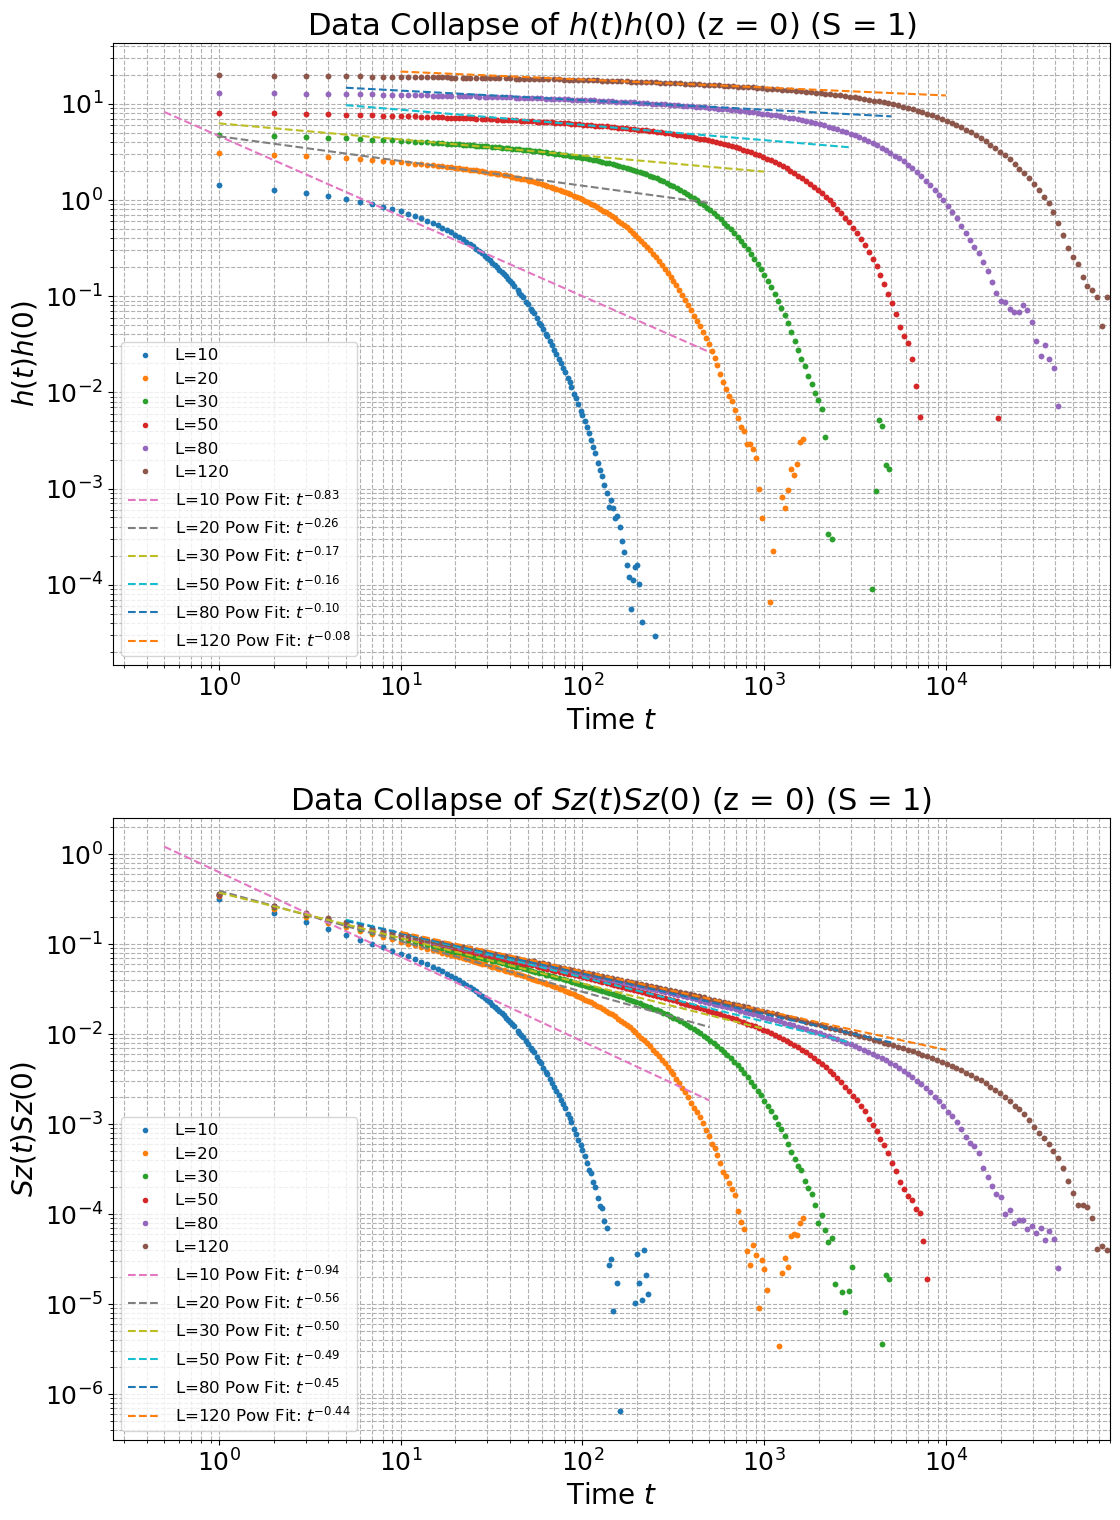


--- Fitting for plot of qm1n0m1n0_t_Avg ---
False

--- Fitting for plot of om1n0m1n0_t_Avg ---
False

--- Fitting for plot of qm1n1m1n1_t_Avg ---
False

--- Fitting for plot of om1n1m1n1_t_Avg ---
False

--- Fitting for plot of qm2n2m2n2_t_Avg ---
False

--- Fitting for plot of om2n2m2n2_t_Avg ---
False


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90635/462549588.py:226: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])



Plot saved as fig/S1_Z_and_O_correlations.png


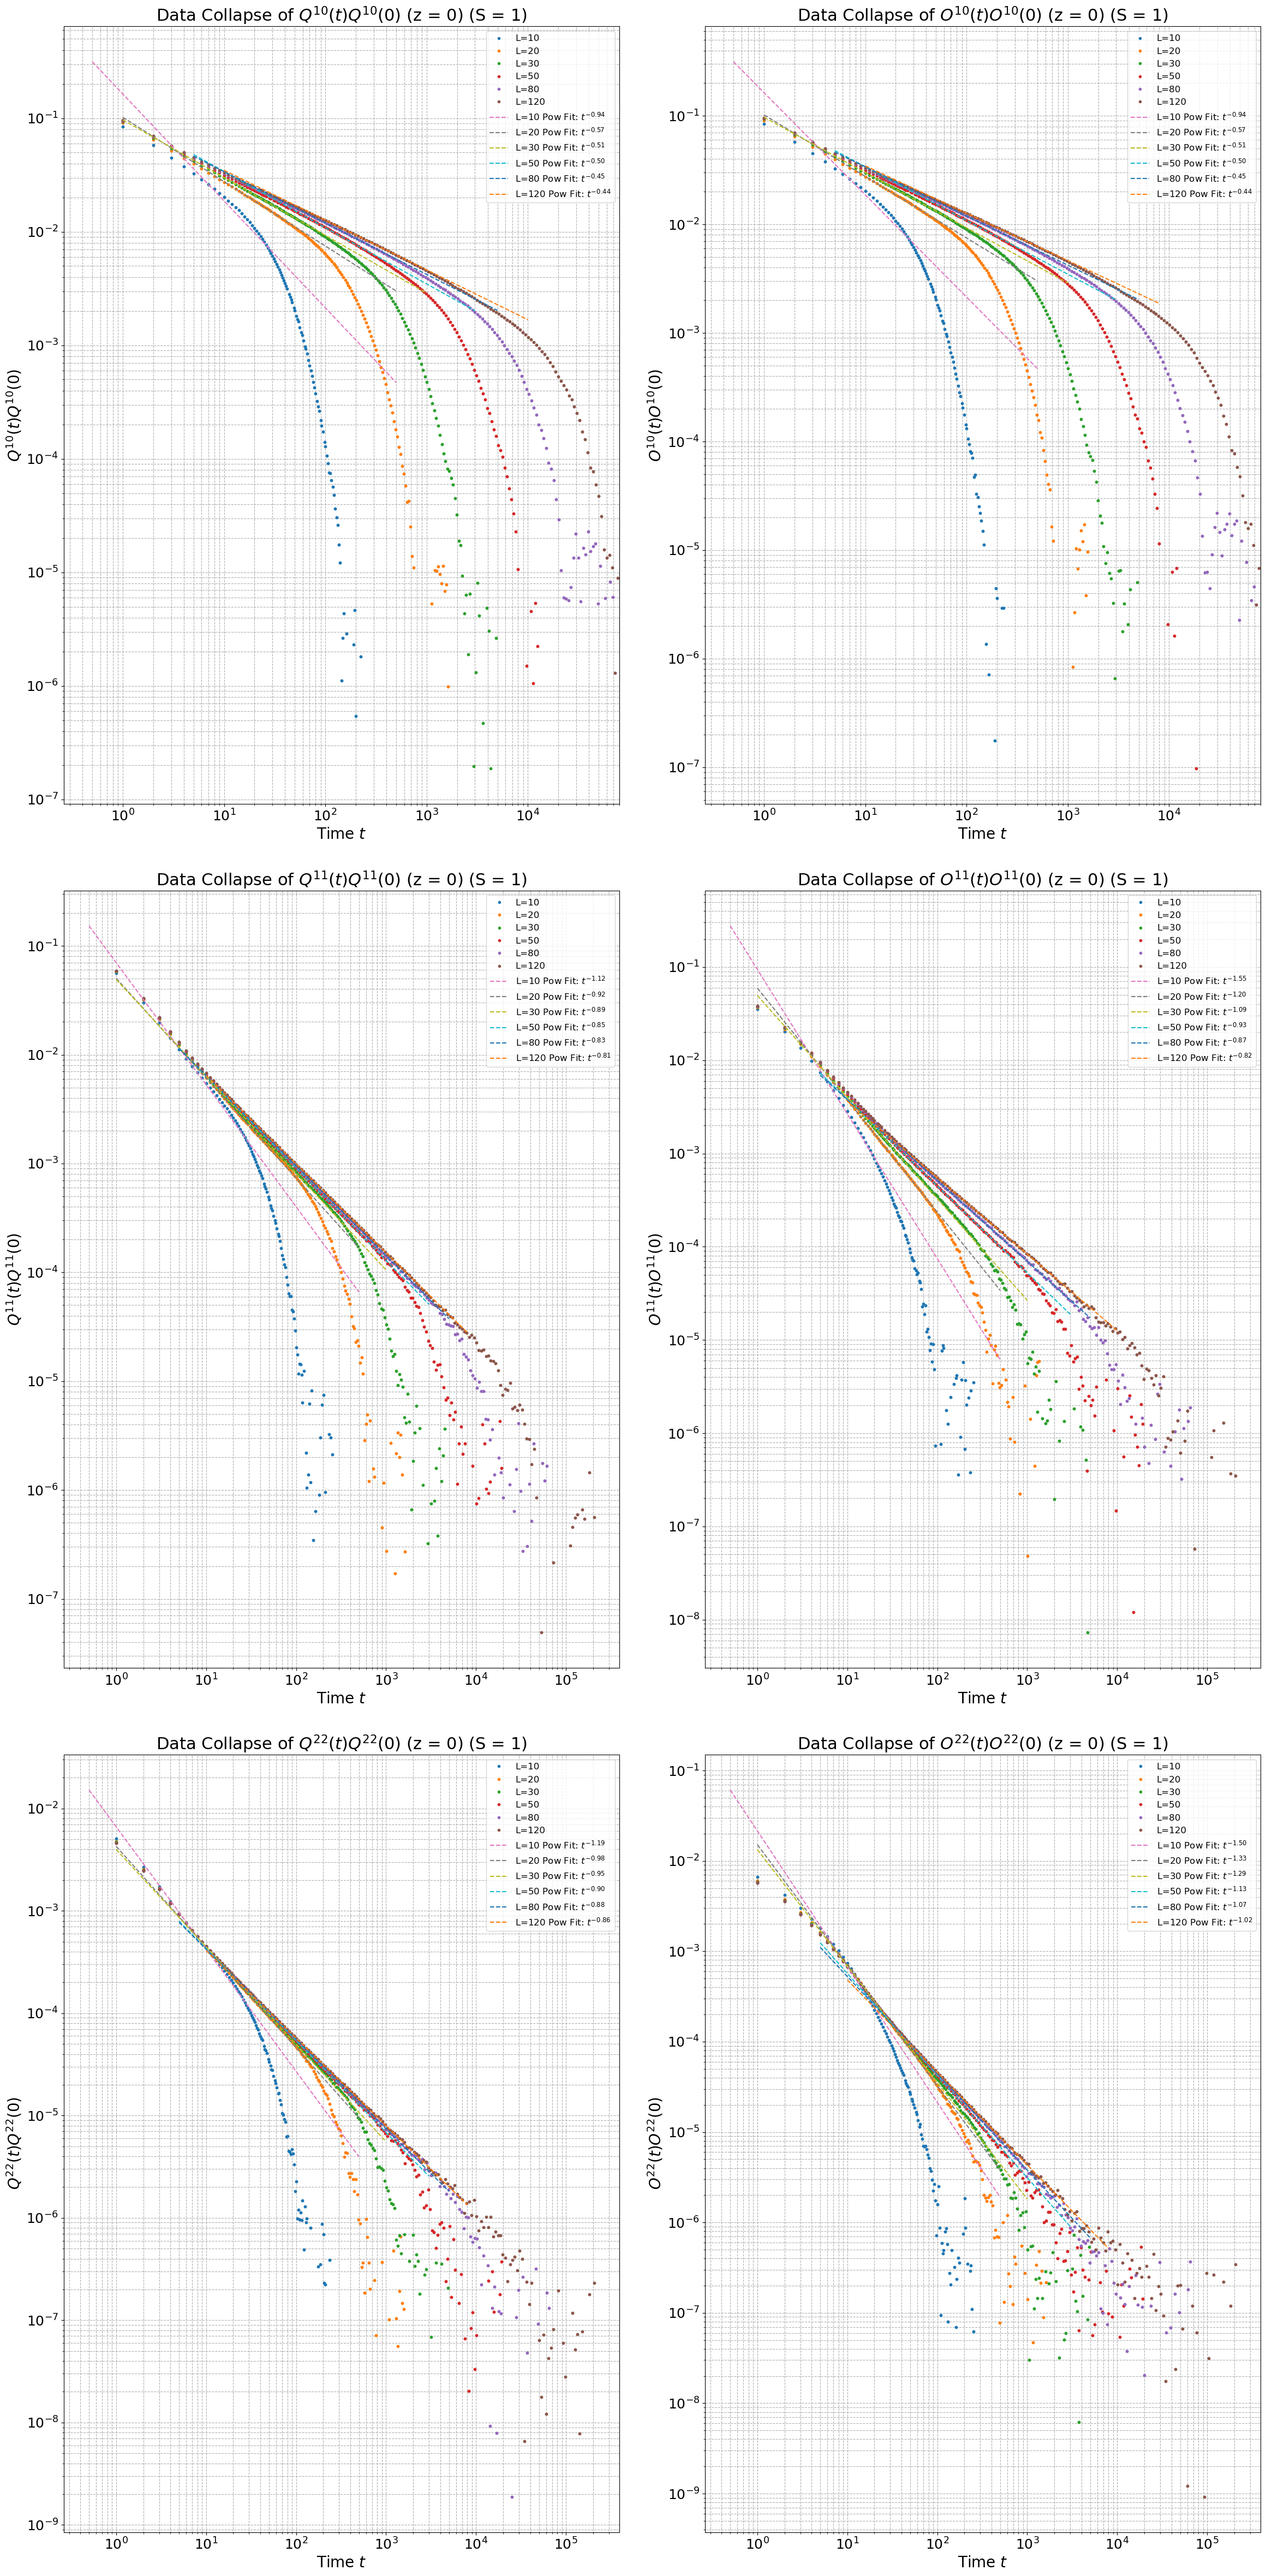

--- Generating Figure 1: Z and O Correlations ---

--- Fitting for plot of h_t_Avg ---
False

--- Fitting for plot of SzSz_t_Avg ---
False

--- Fitting for plot of AA_t_Avg ---
False

--- Fitting for plot of BB_t_Avg ---
False

--- Fitting for plot of CC_t_Avg ---
False

--- Fitting for plot of DD_t_Avg ---
False


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90635/462549588.py:226: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])



Plot saved as fig/S2_Z_and_O_correlations.png


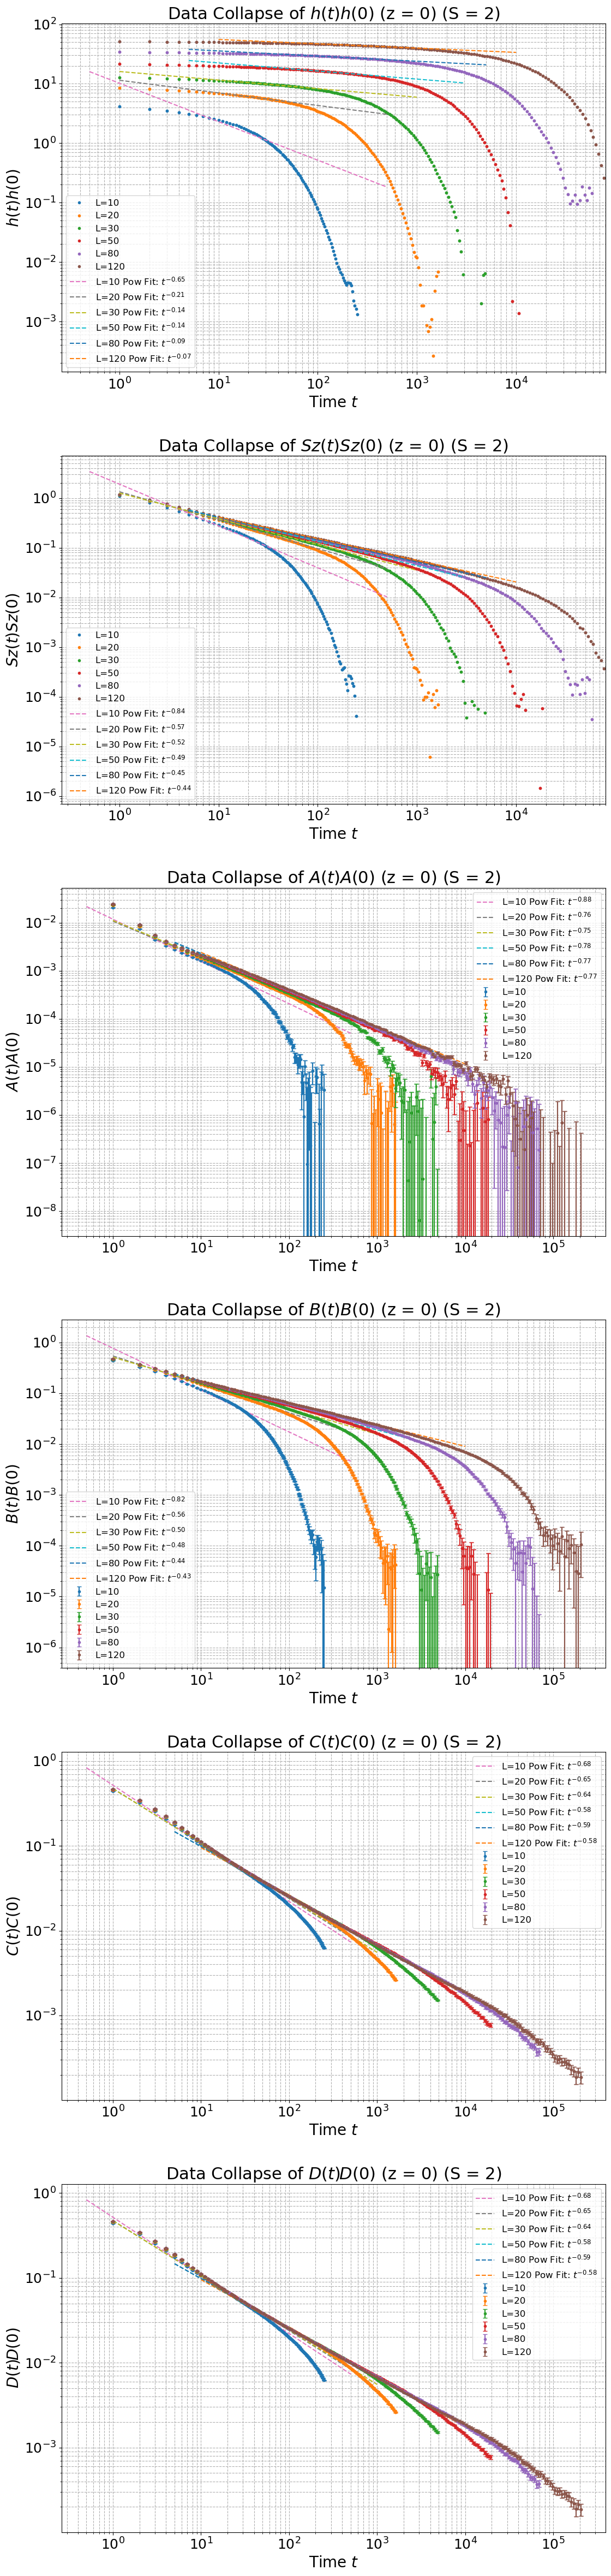


--- Fitting for plot of qm1n0m1n0_t_Avg ---
False

--- Fitting for plot of om1n0m1n0_t_Avg ---
False

--- Fitting for plot of qm1n1m1n1_t_Avg ---
False

--- Fitting for plot of om1n1m1n1_t_Avg ---
False

--- Fitting for plot of qm2n2m2n2_t_Avg ---
False

--- Fitting for plot of om2n2m2n2_t_Avg ---
False


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90635/462549588.py:226: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])



Plot saved as fig/S2_Z_and_O_correlations.png


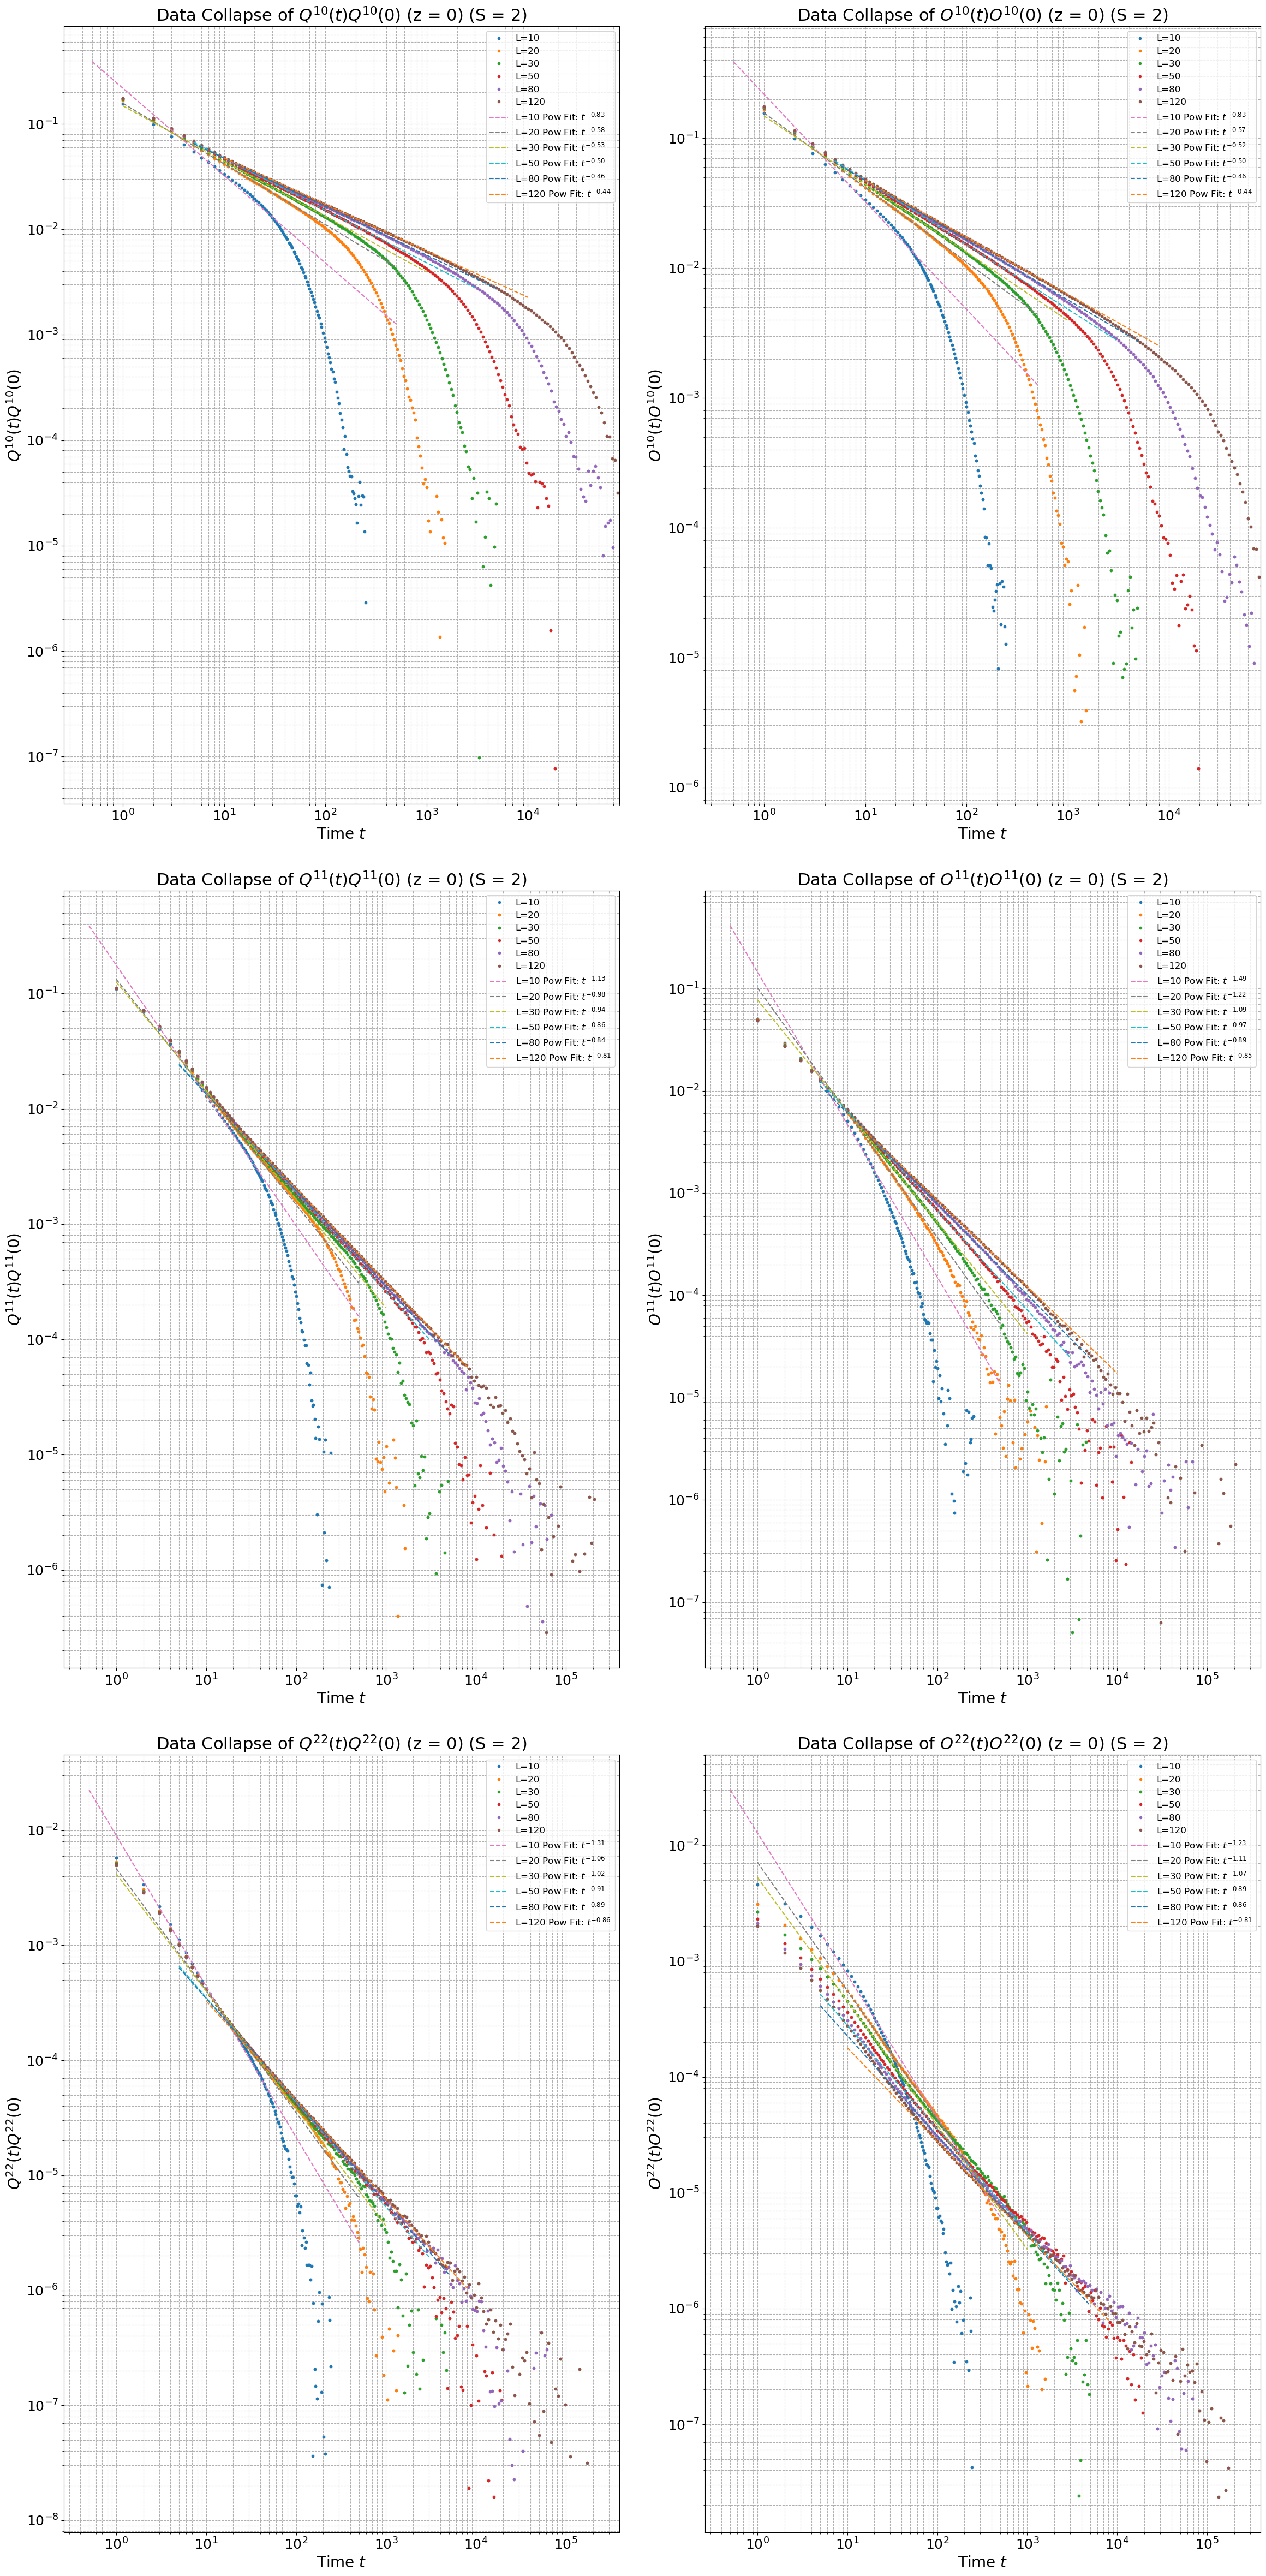

In [26]:

# --- Main execution block ---
if __name__ == '__main__':
    output_dir = "fig"
    os.makedirs(output_dir, exist_ok=True)
    
  
    Z_EXPONENT = 0
    for S_VALUE in [1,2]:
        datasets_to_run = [
            {"L": 10, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 20, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 30, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 50, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 80, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 100, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 120, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            # {"L": 200, "S": S_VALUE, "T": 100000000, "Tthm": 1000000000, "plot_errorbars": True},
            # {"L": 1000, "S": S_VALUE, "T": 10000000, "Tthm": 1000000000, "plot_errorbars": True},
        ]

        # --- EXAMPLE 1: Generate the original Z and O correlation plot ---
        print("--- Generating Figure 1: Z and O Correlations ---")
        
        # Define the configuration for the first figure
        plot_configs_1 = [
            {
                'data_col': 'h_t_Avg',
                'err_col': 'h_t_Err ',
                'label': 'h(t)h(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                ]
            },
            {
                'data_col': 'SzSz_t_Avg',
                'err_col': 'SzSz_t_Err ',
                'label': 'Sz(t)Sz(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                ]
            },

        ]
        if S_VALUE > 1:
            plot_configs_1.extend([      
            {
                'data_col': 'AA_t_Avg',
                'err_col': 'AA_t_Err',
                'label': 'A(t)A(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                ]
            },
            {
                'data_col': 'BB_t_Avg',
                'err_col': 'BB_t_Err',
                'label': 'B(t)B(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ],
                'coef': 1
            },
            {
                'data_col': 'CC_t_Avg',
                'err_col': 'CC_t_Err',
                'label': 'C(t)C(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'coef': 1,
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'DD_t_Avg',
                'err_col': 'DD_t_Err',
                'label': 'D(t)D(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            }])
        
        axis_limits = {
                'ax1': {'xlim': (0, 80000)},
                'ax2': {'xlim': (0, 80000)}
            }
        
        tau_results = generate_collapse_plot(
            datasets=datasets_to_run,
            plot_configs=plot_configs_1,
            z=Z_EXPONENT,
            output_filename=os.path.join(output_dir, f"S{S_VALUE}_Z_and_O_correlations.png"),
            do_parametric_plot=False, # We can still show the parametric plot here，
            fit_config_parametric = [(1000, (0.01, 0.1))],
            axis_limits = axis_limits
        )

        plot_configs_2 = [
                {
                'data_col': 'qm1n0m1n0_t_Avg',
                'err_col': 'qm1n0m1n0_t_Err ',
                'label': 'Q^{10}(t)Q^{10}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'om1n0m1n0_t_Avg',
                'err_col': 'om1n0m1n0_t_Err ',
                'label': 'O^{10}(t)O^{10}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 800), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'qm1n1m1n1_t_Avg',
                'err_col': 'qm1n1m1n1_t_Err ',
                'label': 'Q^{11}(t)Q^{11}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 800), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'om1n1m1n1_t_Avg',
                'err_col': 'om1n1m1n1_t_Err ',
                'label': 'O^{11}(t)O^{11}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'qm2n2m2n2_t_Avg',
                'err_col': 'qm2n2m2n2_t_Err ',
                'label': 'Q^{22}(t)Q^{22}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 800), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            {
                'data_col': 'om2n2m2n2_t_Avg',
                'err_col': 'om2n2m2n2_t_Err ',
                'label': 'O^{22}(t)O^{22}(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                # (100, (50, 500), 'power'),
                (120, (100, 800), 'power'),
                # (1000, (10000, 20000), 'exp'),
                ]
            },
            
        ]
        tau_results = generate_collapse_plot(
            datasets=datasets_to_run,
            plot_configs=plot_configs_2,
            z=Z_EXPONENT,
            output_filename=os.path.join(output_dir, f"S{S_VALUE}_Z_and_O_correlations.png"),
            do_parametric_plot=False, # We can still show the parametric plot here，
            fit_config_parametric = [(1000, (0.01, 0.1))],
            axis_limits = axis_limits,
            ncols=2
        )
    # # --- 3. 将结果保存到 JSON 文件 ---
    #     if tau_results: # 确保结果字典不为空
    #         output_file_path = f"S{S_VALUE}tau_results.json"
    #         try:
    #             with open(output_file_path, 'w') as f:
    #                 # json.dump 会将字典写入文件
    #                 # indent=4 参数会让文件格式化，更易于阅读
    #                 json.dump(tau_results, f, indent=4)
    #             print(f"\n✅ Fitted tau values successfully saved to {output_file_path}")
    #         except Exception as e:
    #             print(f"\n❌ Error saving file: {e}")
    #     else:
    #         print("\nNo tau values to save.")

--- Generating Figure 1: Z and O Correlations ---

--- Fitting for plot of P1_Avg ---


KeyError: 'P1_Avg'

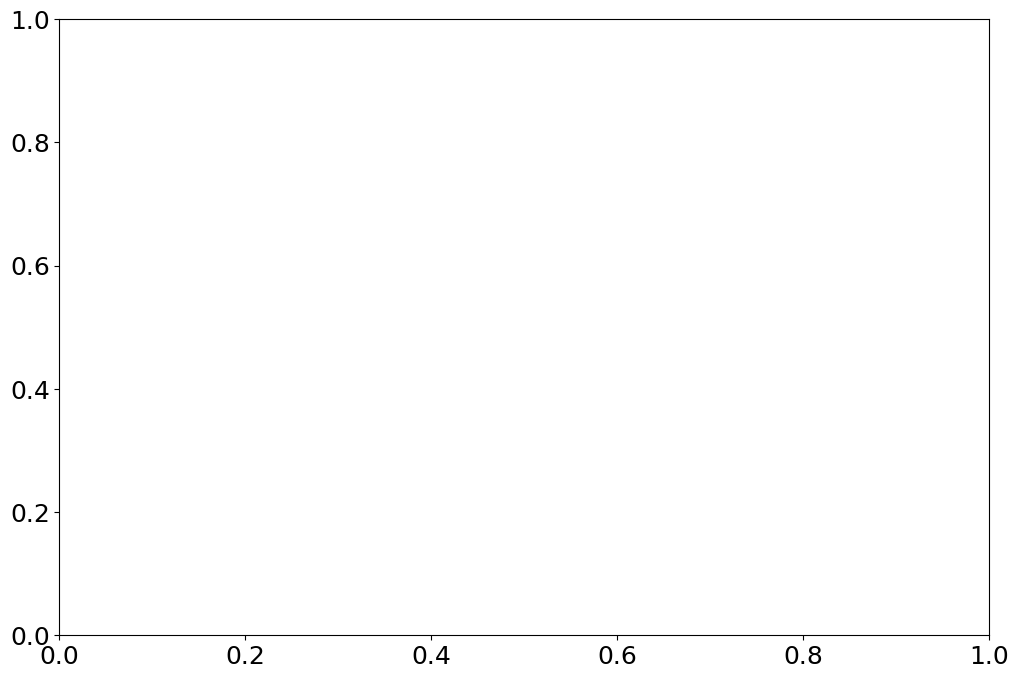

In [9]:

# --- Main execution block ---
if __name__ == '__main__':
    output_dir = "fig"
    os.makedirs(output_dir, exist_ok=True)
    
  
    Z_EXPONENT = 0
    for S_VALUE in [1,2]:
        datasets_to_run = [
            {"L": 10, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 20, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 30, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 50, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 80, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 100, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 120, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            # {"L": 200, "S": S_VALUE, "T": 100000000, "Tthm": 1000000000, "plot_errorbars": True},
            # {"L": 1000, "S": S_VALUE, "T": 10000000, "Tthm": 1000000000, "plot_errorbars": True},
        ]

        # --- EXAMPLE 1: Generate the original Z and O correlation plot ---
        print("--- Generating Figure 1: Z and O Correlations ---")
        
        # Define the configuration for the first figure
        plot_configs_1 = [
            {
                'data_col': 'P1_Avg',
                'err_col': 'P1_Err ',
                'label': 'P_1(t)P_1(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                ]
            },
            
        ]
        axis_limits = {
                'ax1': {'xlim': (0, 80000)},
                'ax2': {'xlim': (0, 80000)}
            }
        tau_results = generate_collapse_plot(
            datasets=datasets_to_run,
            plot_configs=plot_configs_1,
            z=Z_EXPONENT,
            output_filename=os.path.join(output_dir, f"S{S_VALUE}_Z_and_O_correlations.png"),
            do_parametric_plot=False, # We can still show the parametric plot here，
            fit_config_parametric = [(1000, (0.01, 0.1))],
            axis_limits = axis_limits
        )
    # --- 3. 将结果保存到 JSON 文件 ---
        if tau_results: # 确保结果字典不为空
            output_file_path = f"S{S_VALUE}tau_results.json"
            try:
                with open(output_file_path, 'w') as f:
                    # json.dump 会将字典写入文件
                    # indent=4 参数会让文件格式化，更易于阅读
                    json.dump(tau_results, f, indent=4)
                print(f"\n✅ Fitted tau values successfully saved to {output_file_path}")
            except Exception as e:
                print(f"\n❌ Error saving file: {e}")
        else:
            print("\nNo tau values to save.")

--- Generating Figure 1: Z and O Correlations ---
An error occurred with the first data source: 'AutoZ'
An error occurred with the first data source: 'AutoZ'
An error occurred with the first data source: 'AutoZ'
An error occurred with the first data source: 'AutoZ'
An error occurred with the first data source: 'AutoZ'
An error occurred with the first data source: 'AutoZ'

--- Fitting for plot of CC_t_Avg ---
False

Plot saved as fig/S2_Z_and_O_correlations.png


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_68074/2715798547.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(); ax.grid(True, which="both", ls="--")
/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_68074/2715798547.py:230: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if 'xlim' in axis_limits[ax_name]: ax.set_xlim(axis_limits[ax_name]['xlim'])


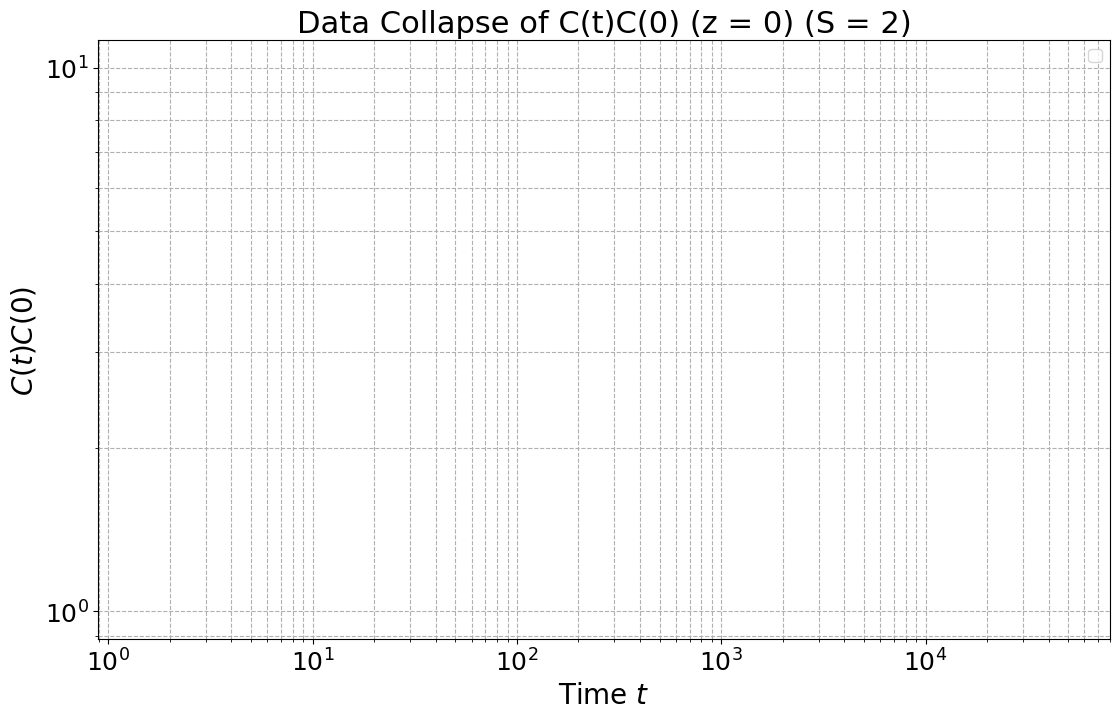

In [ ]:

# --- Main execution block ---
if __name__ == '__main__':
    output_dir = "fig"
    os.makedirs(output_dir, exist_ok=True)
    
    Z_EXPONENT = 0
    for S_VALUE in [2]:
        datasets_to_run = [
            {"L": 10, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 20, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 30, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 50, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 80, "S": S_VALUE, "T":  10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 100, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            {"L": 120, "S": S_VALUE, "T": 10000000, "Tthm": 10000000, "plot_errorbars": True},
            # {"L": 200, "S": S_VALUE, "T": 100000000, "Tthm": 1000000000, "plot_errorbars": True},
            # {"L": 1000, "S": S_VALUE, "T": 10000000, "Tthm": 1000000000, "plot_errorbars": True},
        ]

        # --- EXAMPLE 1: Generate the original Z and O correlation plot ---
        print("--- Generating Figure 1: Z and O Correlations ---")
        
        # Define the configuration for the first figure
        plot_configs_2 = [
            {
                'data_col': 'CC_t_Avg',
                'err_col': 'CC_t_Err',
                'label': 'C(t)C(0)',
                'scaling_exponent': 0, # Formerly DeltaZ2
                'log_power': 0,        # Formerly log_power_Z
                'fit_configs': [       # Fits for this specific plot
                (10, (5, 50), 'power'),
                (20, (10, 50), 'power'),
                (30, (10, 100), 'power'),
                (50, (50, 300), 'power'),
                (80, (50, 500), 'power'),
                (100, (50, 500), 'power'),
                (120, (100, 1000), 'power'),
                ]
            },
            
        ]
        axis_limits = {
                'ax1': {'xlim': (0, 80000)},
                'ax2': {'xlim': (0, 80000)}
            }
        tau_results = generate_collapse_plot(
            datasets=datasets_to_run,
            plot_configs=plot_configs_2,
            z=Z_EXPONENT,
            output_filename=os.path.join(output_dir, f"S{S_VALUE}_Z_and_O_correlations.png"),
            do_parametric_plot=False, # We can still show the parametric plot here，
            fit_config_parametric = [(1000, (0.01, 0.1))],
            axis_limits = axis_limits
        )
    

### Raw Data

### Data Collapse